In [1]:
%%capture
!pip install -qq ipywidgets
!pip install -qq autogluon scikit-learn==1.5.2

In [2]:
%%capture
!apt-get -qq install -y graphviz graphviz-dev && pip install -qq pydot
!pip install -qq pygraphviz

In [3]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import shap

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
# plt.style.use("ggplot")
sns.set_style("whitegrid")

## -- Define ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [4]:
OOF = pd.DataFrame()
PREDS = pd.DataFrame()
print("Loading data: ", end="")
for (root, dirs, files) in os.walk("/kaggle/input/s5e9-beats-oof"):
    for i, file in enumerate(sorted(files), 1):
        if i%10 == 0: print(f"{i}%.. ", end="")
        if file.endswith(".parquet") and "oof" in file:
            OOF = pd.concat([OOF, pd.read_parquet(os.path.join(root, file))], axis=1)
        elif file.endswith(".parquet") and "pred" in file:
            PREDS = pd.concat([PREDS, pd.read_parquet(os.path.join(root, file))], axis=1)
print()

# Optional: Drop weighted(AutoGluon) columns from OOF
oof_columns_to_drop = [col for col in OOF.columns if 'Weighted' in col]# or 'L2' in col]
OOF = OOF.drop(columns=oof_columns_to_drop)

# Optional: Drop weighted(AutoGluon) columns from PREDS
pred_columns_to_drop = [col for col in PREDS.columns if 'Weighted' in col]# or 'L2' in col]
PREDS = PREDS.drop(columns=pred_columns_to_drop)

print(f"{COLOR}Total OOF models  : {len(OOF.columns)}")
print(f"Total PREDS models: {len(PREDS.columns)}")
OOF.head()

Loading data: 10%.. 10%.. 20%.. 30%.. 40%.. 50%.. 60%.. 70%.. 80%.. 90%.. 100%.. 
Total OOF models  : 400
Total PREDS models: 400


,XGB_45xxxx,LGBM_45xxxx,CAT_45xxxx,LightGBMXTBAGL1_FE136_CPU,LightGBMBAGL1_FE136_CPU,RandomForestMSEBAGL1_FE136_CPU,LightGBMXTBAGL2_FE136_CPU,LightGBMBAGL2_FE136_CPU,RandomForestMSEBAGL2_FE136_CPU,CatBoostBAGL2_FE136_CPU,RandomForestMSEBAGL1_FE185--rfx_CPU,ExtraTreesMSEBAGL1_FE185--rfx_CPU,NeuralNetFastAIBAGL1_FE185--rfx_CPU,RandomForestMSEBAGL2_FE185--rfx_CPU,RandomForestMSEBAGL1_FE99rlfx_CPU,ExtraTreesMSEBAGL1_FE99rlfx_CPU,NeuralNetFastAIBAGL1_FE99rlfx_CPU,NeuralNetTorchBAGL1_FE99rlfx_CPU,RandomForestMSEBAGL2_FE99rlfx_CPU,LightGBMXTBAGL1_FE185rlf_CPU,LightGBMBAGL1_FE185rlf_CPU,RandomForestMSEBAGL1_FE185rlf_CPU,NeuralNetFastAIBAGL1_FE185rlf_CPU,LightGBMLargeBAGL1_FE185rlf_CPU,LightGBMr131BAGL1_FE185rlf_CPU,NeuralNetFastAIr191BAGL1_FE185rlf_CPU,LightGBMr96BAGL1_FE185rlf_CPU,LightGBMXTBAGL2_FE185rlf_CPU,LightGBMBAGL2_FE185rlf_CPU,RandomForestMSEBAGL2_FE185rlf_CPU,LightGBMLargeBAGL2_FE185rlf_CPU,CAT_460434,LGBM_461364,LightGBMXTBAGL1_FEnums184_CPU,LightGBMBAGL1_FEnums184_CPU,RandomForestMSEBAGL1_FEnums184_CPU,CatBoostBAGL1_FEnums184_CPU,ExtraTreesMSEBAGL1_FEnums184_CPU,NeuralNetFastAIBAGL1_FEnums184_CPU,XGBoostBAGL1_FEnums184_CPU,LightGBMLargeBAGL1_FEnums184_CPU,LightGBMXTBAGL2_FEnums184_CPU,LightGBMBAGL2_FEnums184_CPU,RandomForestMSEBAGL2_FEnums184_CPU,LightGBMXTBAGL1_FE185_GPU,LightGBMBAGL1_FE185_GPU,RandomForestMSEBAGL1_FE185_GPU,CatBoostBAGL1_FE185_GPU,ExtraTreesMSEBAGL1_FE185_GPU,NeuralNetFastAIBAGL1_FE185_GPU,XGBoostBAGL1_FE185_GPU,NeuralNetTorchBAGL1_FE185_GPU,LightGBMLargeBAGL1_FE185_GPU,CatBoostr177BAGL1_FE185_GPU,NeuralNetTorchr79BAGL1_FE185_GPU,LightGBMr131BAGL1_FE185_GPU,CatBoostr9BAGL1_FE185_GPU,LightGBMXTBAGL2_FE185_GPU,LightGBMBAGL2_FE185_GPU,RandomForestMSEBAGL2_FE185_GPU,CatBoostBAGL2_FE185_GPU,NeuralNetFastAIBAGL2_FE185_GPU,XGBoostBAGL2_FE185_GPU,LightGBMXTBAGL1_FE185__CPU,LightGBMBAGL1_FE185__CPU,RandomForestMSEBAGL1_FE185__CPU,CatBoostBAGL1_FE185__CPU,ExtraTreesMSEBAGL1_FE185__CPU,XGBoostBAGL1_FE185__CPU,LightGBMLargeBAGL1_FE185__CPU,LightGBMXTBAGL2_FE185__CPU,LightGBMBAGL2_FE185__CPU,RandomForestMSEBAGL2_FE185__CPU,RandomForestMSEBAGL1_FE185rfx_CPU,ExtraTreesMSEBAGL1_FE185rfx_CPU,NeuralNetFastAIBAGL1_FE185rfx_CPU,NeuralNetFastAIr191BAGL1_FE185rfx_CPU,RandomForestMSEBAGL2_FE185rfx_CPU,ExtraTreesMSEBAGL2_FE185rfx_CPU,RandomForestMSEBAGL1_FE185rfx_GPU,ExtraTreesMSEBAGL1_FE185rfx_GPU,NeuralNetFastAIBAGL1_FE185rfx_GPU,NeuralNetFastAIr191BAGL1_FE185rfx_GPU,ExtraTreesr42BAGL1_FE185rfx_GPU,RandomForestMSEBAGL2_FE185rfx_GPU,RandomForestMSEBAGL1_FE185rfx__CPU,ExtraTreesMSEBAGL1_FE185rfx__CPU,NeuralNetFastAIBAGL1_FE185rfx__CPU,NeuralNetFastAIr191BAGL1_FE185rfx__CPU,RandomForestMSEBAGL2_FE185rfx__CPU,LightGBMXTBAGL1_FE185rlfx_CPU,LightGBMBAGL1_FE185rlfx_CPU,RandomForestMSEBAGL1_FE185rlfx_CPU,ExtraTreesMSEBAGL1_FE185rlfx_CPU,NeuralNetFastAIBAGL1_FE185rlfx_CPU,LightGBMLargeBAGL1_FE185rlfx_CPU,LightGBMXTBAGL2_FE185rlfx_CPU,LightGBMBAGL2_FE185rlfx_CPU,RandomForestMSEBAGL2_FE185rlfx_CPU,ExtraTreesMSEBAGL2_FE185rlfx_CPU,LightGBMXTBAGL1_FE194_CPU,LightGBMBAGL1_FE194_CPU,RandomForestMSEBAGL1_FE194_CPU,CatBoostBAGL1_FE194_CPU,ExtraTreesMSEBAGL1_FE194_CPU,XGBoostBAGL1_FE194_CPU,LightGBMXTBAGL2_FE194_CPU,LightGBMBAGL2_FE194_CPU,RandomForestMSEBAGL2_FE194_CPU,LightGBMXTBAGL1_FE194xlc_CPU,LightGBMBAGL1_FE194xlc_CPU,CatBoostBAGL1_FE194xlc_CPU,XGBoostBAGL1_FE194xlc_CPU,LightGBMLargeBAGL1_FE194xlc_CPU,CatBoostr177BAGL1_FE194xlc_CPU,LightGBMr131BAGL1_FE194xlc_CPU,CatBoostr9BAGL1_FE194xlc_CPU,LightGBMr96BAGL1_FE194xlc_CPU,XGBoostr33BAGL1_FE194xlc_CPU,CatBoostr137BAGL1_FE194xlc_CPU,CatBoostr13BAGL1_FE194xlc_CPU,LightGBMr188BAGL1_FE194xlc_CPU,XGBoostr89BAGL1_FE194xlc_CPU,LightGBMr130BAGL1_FE194xlc_CPU,CatBoostr50BAGL1_FE194xlc_CPU,XGBoostr194BAGL1_FE194xlc_CPU,CatBoostr69BAGL1_FE194xlc_CPU,LightGBMr161BAGL1_FE194xlc_CPU,CatBoostr70BAGL1_FE194xlc_CPU,LightGBMr196BAGL1_FE194xlc_CPU,CatBoostr167BAGL1_FE194xlc_CPU,XGBoostr98BAGL1_FE194xlc_CPU,LightGBMr15BAGL1_FE194xlc_CPU,CatBoostr86BAGL1_FE194xlc_CPU,CatBoostr49BAGL1_FE194xlc_CPU,LightGBMr143

In [5]:
def rename_duplicate_cols(df: pd.DataFrame) -> pd.DataFrame:
    original_cols = list(df.columns)
    new_cols = []
    # Track how many times we've seen each original name
    seen = {}

    for col in tqdm(original_cols, desc="Fixing columns"):
        if col not in seen:
            # First occurrence: keep name unchanged
            seen[col] = 1
            new_cols.append(col)
        else:
            # Duplicate: append suffix _k where k starts at 0
            suffix = seen[col] - 1 # 0 for first duplicate, 1 for second...
            new_name = f"{col}_{suffix}"
            new_cols.append(new_name)
            seen[col] += 1

    # Apply new column names
    df = df.copy()
    df.columns = new_cols
    print(f"{COLOR}{len(new_cols)} Columns fixed!!!{RESET}")

    return df

train = rename_duplicate_cols(OOF)
test = rename_duplicate_cols(PREDS)

Fixing columns:   0%|          | 0/400 [00:00<?, ?it/s]

400 Columns fixed!!!


Fixing columns:   0%|          | 0/400 [00:00<?, ?it/s]

400 Columns fixed!!!


In [6]:
PATH    = "/kaggle/input/playground-series-s5e9/"
TR      = pd.read_csv(PATH + "train.csv", index_col='id') #.drop('id', axis=1) 
TARGET  = "BeatsPerMinute"
train   = pd.concat([train, TR[TARGET]], axis=1)
submit  = pd.read_csv(PATH+"sample_submission.csv")
print(f"Shape of train data: {train.shape}")
train.head()

Shape of train data: (524164, 401)


,XGB_45xxxx,LGBM_45xxxx,CAT_45xxxx,LightGBMXTBAGL1_FE136_CPU,LightGBMBAGL1_FE136_CPU,RandomForestMSEBAGL1_FE136_CPU,LightGBMXTBAGL2_FE136_CPU,LightGBMBAGL2_FE136_CPU,RandomForestMSEBAGL2_FE136_CPU,CatBoostBAGL2_FE136_CPU,RandomForestMSEBAGL1_FE185--rfx_CPU,ExtraTreesMSEBAGL1_FE185--rfx_CPU,NeuralNetFastAIBAGL1_FE185--rfx_CPU,RandomForestMSEBAGL2_FE185--rfx_CPU,RandomForestMSEBAGL1_FE99rlfx_CPU,ExtraTreesMSEBAGL1_FE99rlfx_CPU,NeuralNetFastAIBAGL1_FE99rlfx_CPU,NeuralNetTorchBAGL1_FE99rlfx_CPU,RandomForestMSEBAGL2_FE99rlfx_CPU,LightGBMXTBAGL1_FE185rlf_CPU,LightGBMBAGL1_FE185rlf_CPU,RandomForestMSEBAGL1_FE185rlf_CPU,NeuralNetFastAIBAGL1_FE185rlf_CPU,LightGBMLargeBAGL1_FE185rlf_CPU,LightGBMr131BAGL1_FE185rlf_CPU,NeuralNetFastAIr191BAGL1_FE185rlf_CPU,LightGBMr96BAGL1_FE185rlf_CPU,LightGBMXTBAGL2_FE185rlf_CPU,LightGBMBAGL2_FE185rlf_CPU,RandomForestMSEBAGL2_FE185rlf_CPU,LightGBMLargeBAGL2_FE185rlf_CPU,CAT_460434,LGBM_461364,LightGBMXTBAGL1_FEnums184_CPU,LightGBMBAGL1_FEnums184_CPU,RandomForestMSEBAGL1_FEnums184_CPU,CatBoostBAGL1_FEnums184_CPU,ExtraTreesMSEBAGL1_FEnums184_CPU,NeuralNetFastAIBAGL1_FEnums184_CPU,XGBoostBAGL1_FEnums184_CPU,LightGBMLargeBAGL1_FEnums184_CPU,LightGBMXTBAGL2_FEnums184_CPU,LightGBMBAGL2_FEnums184_CPU,RandomForestMSEBAGL2_FEnums184_CPU,LightGBMXTBAGL1_FE185_GPU,LightGBMBAGL1_FE185_GPU,RandomForestMSEBAGL1_FE185_GPU,CatBoostBAGL1_FE185_GPU,ExtraTreesMSEBAGL1_FE185_GPU,NeuralNetFastAIBAGL1_FE185_GPU,XGBoostBAGL1_FE185_GPU,NeuralNetTorchBAGL1_FE185_GPU,LightGBMLargeBAGL1_FE185_GPU,CatBoostr177BAGL1_FE185_GPU,NeuralNetTorchr79BAGL1_FE185_GPU,LightGBMr131BAGL1_FE185_GPU,CatBoostr9BAGL1_FE185_GPU,LightGBMXTBAGL2_FE185_GPU,LightGBMBAGL2_FE185_GPU,RandomForestMSEBAGL2_FE185_GPU,CatBoostBAGL2_FE185_GPU,NeuralNetFastAIBAGL2_FE185_GPU,XGBoostBAGL2_FE185_GPU,LightGBMXTBAGL1_FE185__CPU,LightGBMBAGL1_FE185__CPU,RandomForestMSEBAGL1_FE185__CPU,CatBoostBAGL1_FE185__CPU,ExtraTreesMSEBAGL1_FE185__CPU,XGBoostBAGL1_FE185__CPU,LightGBMLargeBAGL1_FE185__CPU,LightGBMXTBAGL2_FE185__CPU,LightGBMBAGL2_FE185__CPU,RandomForestMSEBAGL2_FE185__CPU,RandomForestMSEBAGL1_FE185rfx_CPU,ExtraTreesMSEBAGL1_FE185rfx_CPU,NeuralNetFastAIBAGL1_FE185rfx_CPU,NeuralNetFastAIr191BAGL1_FE185rfx_CPU,RandomForestMSEBAGL2_FE185rfx_CPU,ExtraTreesMSEBAGL2_FE185rfx_CPU,RandomForestMSEBAGL1_FE185rfx_GPU,ExtraTreesMSEBAGL1_FE185rfx_GPU,NeuralNetFastAIBAGL1_FE185rfx_GPU,NeuralNetFastAIr191BAGL1_FE185rfx_GPU,ExtraTreesr42BAGL1_FE185rfx_GPU,RandomForestMSEBAGL2_FE185rfx_GPU,RandomForestMSEBAGL1_FE185rfx__CPU,ExtraTreesMSEBAGL1_FE185rfx__CPU,NeuralNetFastAIBAGL1_FE185rfx__CPU,NeuralNetFastAIr191BAGL1_FE185rfx__CPU,RandomForestMSEBAGL2_FE185rfx__CPU,LightGBMXTBAGL1_FE185rlfx_CPU,LightGBMBAGL1_FE185rlfx_CPU,RandomForestMSEBAGL1_FE185rlfx_CPU,ExtraTreesMSEBAGL1_FE185rlfx_CPU,NeuralNetFastAIBAGL1_FE185rlfx_CPU,LightGBMLargeBAGL1_FE185rlfx_CPU,LightGBMXTBAGL2_FE185rlfx_CPU,LightGBMBAGL2_FE185rlfx_CPU,RandomForestMSEBAGL2_FE185rlfx_CPU,ExtraTreesMSEBAGL2_FE185rlfx_CPU,LightGBMXTBAGL1_FE194_CPU,LightGBMBAGL1_FE194_CPU,RandomForestMSEBAGL1_FE194_CPU,CatBoostBAGL1_FE194_CPU,ExtraTreesMSEBAGL1_FE194_CPU,XGBoostBAGL1_FE194_CPU,LightGBMXTBAGL2_FE194_CPU,LightGBMBAGL2_FE194_CPU,RandomForestMSEBAGL2_FE194_CPU,LightGBMXTBAGL1_FE194xlc_CPU,LightGBMBAGL1_FE194xlc_CPU,CatBoostBAGL1_FE194xlc_CPU,XGBoostBAGL1_FE194xlc_CPU,LightGBMLargeBAGL1_FE194xlc_CPU,CatBoostr177BAGL1_FE194xlc_CPU,LightGBMr131BAGL1_FE194xlc_CPU,CatBoostr9BAGL1_FE194xlc_CPU,LightGBMr96BAGL1_FE194xlc_CPU,XGBoostr33BAGL1_FE194xlc_CPU,CatBoostr137BAGL1_FE194xlc_CPU,CatBoostr13BAGL1_FE194xlc_CPU,LightGBMr188BAGL1_FE194xlc_CPU,XGBoostr89BAGL1_FE194xlc_CPU,LightGBMr130BAGL1_FE194xlc_CPU,CatBoostr50BAGL1_FE194xlc_CPU,XGBoostr194BAGL1_FE194xlc_CPU,CatBoostr69BAGL1_FE194xlc_CPU,LightGBMr161BAGL1_FE194xlc_CPU,CatBoostr70BAGL1_FE194xlc_CPU,LightGBMr196BAGL1_FE194xlc_CPU,CatBoostr167BAGL1_FE194xlc_CPU,XGBoostr98BAGL1_FE194xlc_CPU,LightGBMr15BAGL1_FE194xlc_CPU,CatBoostr86BAGL1_FE194xlc_CPU,CatBoostr49BAGL1_FE194xlc_CPU,LightGBMr143

In [7]:
# !rm -r /kaggle/working/AG_beats_models

In [8]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data --
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_beats_models",
).fit(
                   train_data = train,
                      presets = 'best_quality',
                num_bag_folds = 10,
                   time_limit = 3600*11.5,
             dynamic_stacking = False,
             num_stack_levels = 1,
         # included_model_types = ['RF','XT','FASTAI'],
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
                  ag_args_fit = {'num_cpus': os.cpu_count() - 1},
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       26.81 GB / 31.35 GB (85.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=10, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 41400s
AutoGluon will save models to "/kaggle/working/AG_beats_models"
Train Data Rows:    524164
Train Data Columns: 400
Label Column:       BeatsPerMinute
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    27424.73 MB
	Train Data (Original)  Memory Us

In [9]:
## -- Get Summary --
print(f"""
    {'█'*5}| Total models : {len(predictor.model_names())}
    {'█'*5}| Best model   : {predictor.model_best}
        """)

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))


    █████| Total models : 10
    █████| Best model   : WeightedEnsemble_L3
        


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-26.426332,root_mean_squared_error,154.731717,38324.278878,0.009069,0.867913,3,True,10
1,WeightedEnsemble_L2,-26.426489,root_mean_squared_error,9.050619,3533.301097,0.011725,0.542917,2,True,5
2,CatBoost_BAG_L1,-26.427539,root_mean_squared_error,0.993355,1372.287554,0.993355,1372.287554,1,True,4
3,LightGBMXT_BAG_L2,-26.427620,root_mean_squared_error,39.676255,27906.042520,2.552669,757.037279,2,True,6
4,CatBoost_BAG_L2,-26.427756,root_mean_squared_error,37.902787,28148.672868,0.779201,999.667626,2,True,8
5,LightGBMXT_BAG_L1,-26.428479,root_mean_squared_error,4.299096,1183.359593,4.299096,1183.359593,1,True,1
6,LightGBM_BAG_L1,-26.429547,root_mean_squared_error,3.746444,977.111033,3.746444,977.111033,1,True,2
7,LightGBM_BAG_L2,-26.429901,root_mean_squared_error,39.283812,27802.459173,2.160226,653.453932,2,True,7
8,ExtraTreesMSE_BAG_L2,-26.471952,root_mean_squared_error,151.390779,36566.706061,114.267192,9417.700819,2,True,9
9,RandomForestMSE_BAG_L1,-26.688034,root_mean_squared_error,28.084692,23616.247061,28.084692,23616.247061,1,True,3


In [10]:
## -- Create folder directory to save predictions --
NAME_EXT = "_LV2_CPU"
!mkdir /kaggle/working/AG_beats_predictions{NAME_EXT}

In [11]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)
pred_df.head()

0    118.445694
1    118.916145
2    118.295570
3    120.306831
4    119.519463
Name: BeatsPerMinute, dtype: float32

In [12]:
## -- Generate Submission --
FILE_NAME = f"submit_AG{NAME_EXT}.csv"

submit = pd.read_csv(PATH+"sample_submission.csv")
submit["BeatsPerMinute"] = pred_df.values
submit.to_csv(FILE_NAME, index=False)
print(f"{'█'*5}| Submission file {FILE_NAME} saved!")
submit.head(10)

█████| Submission file submit_AG_LV2_CPU.csv saved!


,id,BeatsPerMinute
0,524164,118.445694
1,524165,118.916145
2,524166,118.295570
3,524167,120.306831
4,524168,119.519463
5,524169,117.500389
6,524170,117.562935
7,524171,117.952881
8,524172,119.314384
9,524173,118.748405


In [13]:
## -- Generate prediction probabilities for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Get TEST PREDICTIONS of all models --
final_test_data = {}

for k, v in tqdm(ag_multi_test_proba.items(), desc="Exporting TEST predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(f"/kaggle/working/AG_beats_predictions{NAME_EXT}/predL2_ag{NAME_EXT}.parquet", index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_LV2_CPU,LightGBMBAGL1_LV2_CPU,RandomForestMSEBAGL1_LV2_CPU,CatBoostBAGL1_LV2_CPU,WeightedEnsembleL2_LV2_CPU,LightGBMXTBAGL2_LV2_CPU,LightGBMBAGL2_LV2_CPU,CatBoostBAGL2_LV2_CPU,ExtraTreesMSEBAGL2_LV2_CPU,WeightedEnsembleL3_LV2_CPU
0,118.840111,118.924301,121.519562,118.087524,118.501343,118.340637,118.540085,118.440201,118.313454,118.445694
1,119.049515,118.844032,118.850731,118.919052,118.944458,119.006615,118.923012,118.975365,117.999771,118.916145
2,118.615738,118.660912,114.659729,118.135681,118.397850,118.405334,118.666649,118.302612,116.116547,118.295570
3,120.506104,120.042542,121.603752,120.095497,120.214012,120.369690,120.276695,120.516983,121.745277,120.306831
4,119.465187,119.473122,120.667885,119.555161,119.509476,119.454063,119.609726,119.619041,119.882240,119.519463


In [14]:
## -- Get OOF PREDICTIONS of all models --
ag_multi_oof_preds = {}

for model in tqdm(predictor.model_names(), desc="Processing OOF"):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                         model = model,
                                    train_data = train
                                )

Processing OOF:   0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
## -- Get dataframe from OOF PREDICTIONS of all models --
final_oof_data = {}

for k, v in tqdm(ag_multi_oof_preds.items(), desc="Exporting OOF predictions"):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v

final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(f"/kaggle/working/AG_beats_predictions{NAME_EXT}/oofL2_ag{NAME_EXT}.parquet", index=False)
final_oof_df.head()

Exporting OOF predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_LV2_CPU,LightGBMBAGL1_LV2_CPU,RandomForestMSEBAGL1_LV2_CPU,CatBoostBAGL1_LV2_CPU,WeightedEnsembleL2_LV2_CPU,LightGBMXTBAGL2_LV2_CPU,LightGBMBAGL2_LV2_CPU,CatBoostBAGL2_LV2_CPU,ExtraTreesMSEBAGL2_LV2_CPU,WeightedEnsembleL3_LV2_CPU
0,117.693443,118.426956,106.925102,117.749191,117.874268,117.761543,118.271103,117.906136,115.879700,117.780449
1,118.987396,118.739296,117.282249,118.542160,118.724266,118.850212,118.831337,118.777466,118.498451,118.732025
2,116.231575,118.304871,115.031235,117.480751,117.259773,117.151047,116.924324,117.152206,119.600662,117.368492
3,118.451668,118.865044,121.490578,119.473625,119.022781,119.410179,119.178413,119.211128,120.422180,119.186615
4,118.800819,119.104553,125.993149,118.859718,118.892662,118.977646,118.849709,118.842957,119.161018,118.922089


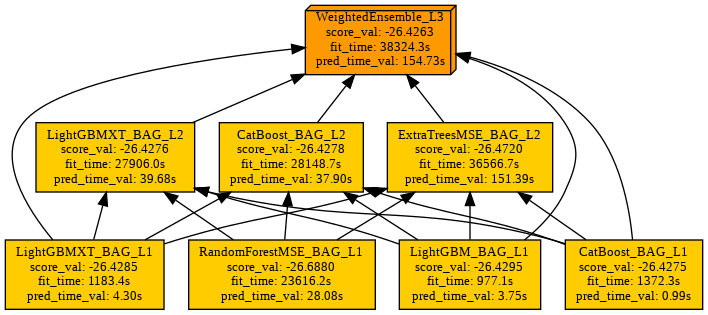

In [16]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_beats_models/ensemble_model.png'))

In [17]:
!zip -r AG_beats_predictions{NAME_EXT}.zip /kaggle/working/AG_beats_predictions{NAME_EXT}

  adding: kaggle/working/AG_beats_predictions_LV2_CPU/ (stored 0%)
  adding: kaggle/working/AG_beats_predictions_LV2_CPU/predL2_ag_LV2_CPU.parquet (deflated 15%)
  adding: kaggle/working/AG_beats_predictions_LV2_CPU/oofL2_ag_LV2_CPU.parquet (deflated 15%)


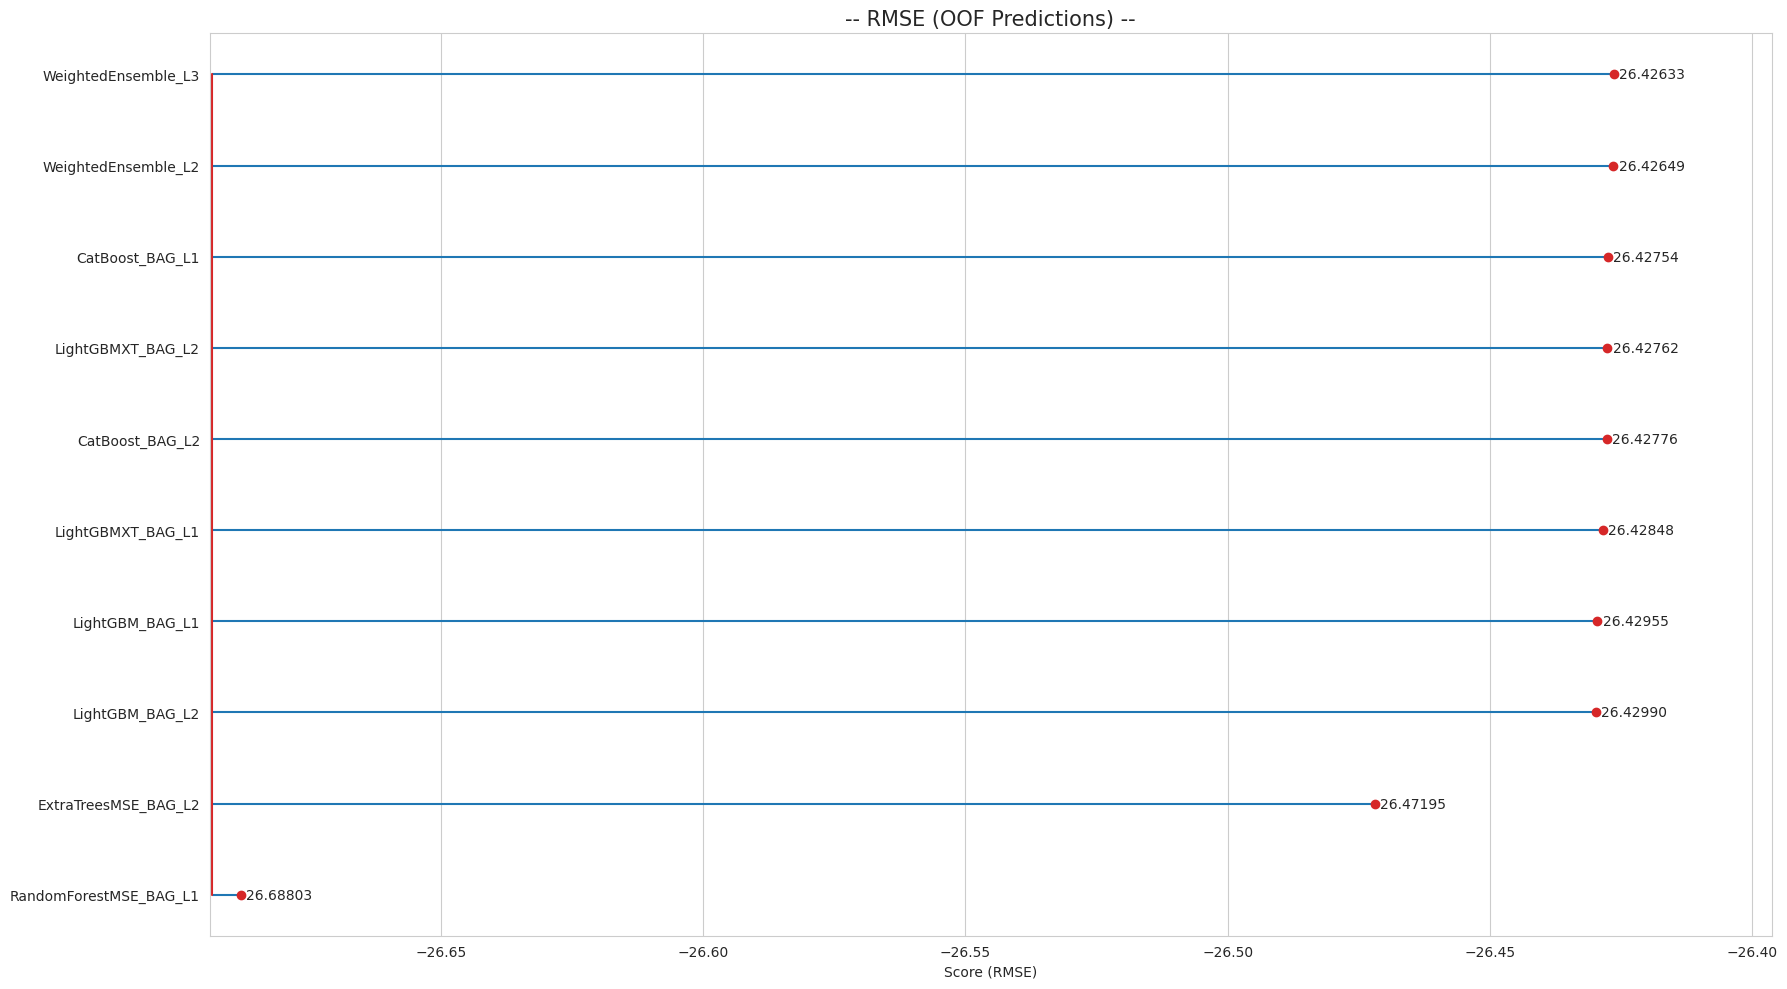

In [18]:
## -- EXTRACT MODEL AND SCORES --
result_dict = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_dict, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 10))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.03)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE (OOF Predictions) --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [19]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_beats_models
!rm -r /kaggle/working/AG_beats_predictions{NAME_EXT}

In [20]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

